In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

Inspect json file

In [2]:
zone = gpd.read_file('../data/MDHA_Promise_Zones/files/Export_Output_5.geojson')
print(zone.crs)
zone.head( )

epsg:4326


,OBJECTID,ZONE_ID,SHAPE_STAr,SHAPE_STLe,geometry
0,1,1,1.053728e+08,49364.601403,"POLYGON ((-78.56795 41.19167, -78.56795 41.191..."
1,2,2,7.670585e+07,45226.018917,"POLYGON ((-78.58438 41.14694, -78.58423 41.146..."
2,3,3,2.985488e+08,75207.067487,"POLYGON ((-78.50866 41.16535, -78.50852 41.165..."
3,4,4,2.713638e+08,74348.596054,"POLYGON ((-78.55109 41.12847, -78.55101 41.128..."
4,5,5,3.928178e+08,106661.712102,"POLYGON ((-78.59154 41.23154, -78.59113 41.230..."


Plot the Promise Zone

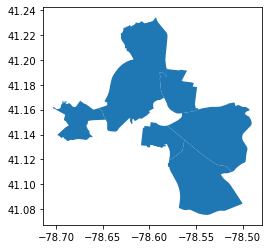

In [3]:
zone.plot();

Read in the pkl file

In [4]:
may = pd.read_pickle('../data/may.pkl')

In [5]:
may.head()

,pubdatetime,latitude,longitude,sumdid,chargelevel,companyname
0,2019-05-01 00:01:41.247,36.136822,-86.799877,PoweredLIRL1,93.0,0
1,2019-05-01 00:01:41.247,36.191252,-86.772945,PoweredXWRWC,35.0,0
2,2019-05-01 00:01:41.247,36.144752,-86.806293,PoweredMEJEH,90.0,0
3,2019-05-01 00:01:41.247,36.162056,-86.774688,Powered1A7TC,88.0,0
4,2019-05-01 00:01:41.247,36.150973,-86.783109,Powered2TYEF,98.0,0


Create geometry column for may.

In [6]:
may['geometry'] = may.apply(lambda x: Point((x.longitude, 
                                            x.latitude)), 
                                        axis=1);

Match the crs

In [7]:
zone.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
may_geo = gpd.GeoDataFrame(may, 
                           crs = zone.crs, 
                           geometry = zone['geometry'])
type(may_geo)
may_geo.head(2)

,pubdatetime,latitude,longitude,sumdid,chargelevel,companyname,geometry
0,2019-05-01 00:01:41.247,36.136822,-86.799877,PoweredLIRL1,93.0,0,"POLYGON ((-78.56795 41.19167, -78.56795 41.191..."
1,2019-05-01 00:01:41.247,36.191252,-86.772945,PoweredXWRWC,35.0,0,"POLYGON ((-78.58438 41.14694, -78.58423 41.146..."


In [9]:
may_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Join the geodataframes with a spatial join. Only keep the zone_id and geometry from promise_zone.

In [10]:
zone = zone[['ZONE_ID', 'geometry']]
zone.head(2)

,ZONE_ID,geometry
0,1,"POLYGON ((-78.56795 41.19167, -78.56795 41.191..."
1,2,"POLYGON ((-78.58438 41.14694, -78.58423 41.146..."


In [11]:
may_zone = gpd.sjoin(may_geo, zone, op = 'within')

In [12]:
may_zone.head()

,pubdatetime,latitude,longitude,sumdid,chargelevel,companyname,geometry,index_right,ZONE_ID
0,2019-05-01 00:01:41.247,36.136822,-86.799877,PoweredLIRL1,93.0,0,"POLYGON ((-78.56795 41.19167, -78.56795 41.191...",0,1
1,2019-05-01 00:01:41.247,36.191252,-86.772945,PoweredXWRWC,35.0,0,"POLYGON ((-78.58438 41.14694, -78.58423 41.146...",1,2
2,2019-05-01 00:01:41.247,36.144752,-86.806293,PoweredMEJEH,90.0,0,"POLYGON ((-78.50866 41.16535, -78.50852 41.165...",2,3
3,2019-05-01 00:01:41.247,36.162056,-86.774688,Powered1A7TC,88.0,0,"POLYGON ((-78.55109 41.12847, -78.55101 41.128...",3,4
4,2019-05-01 00:01:41.247,36.150973,-86.783109,Powered2TYEF,98.0,0,"POLYGON ((-78.59154 41.23154, -78.59113 41.230...",4,5


Inspect the zones

In [13]:
may_zone['ZONE_ID'].value_counts()

1    1
2    1
3    1
4    1
5    1
6    1
Name: ZONE_ID, dtype: int64

Let's focus on zone 6 for now

In [14]:
may_zone6 = may_zone.loc[may_zone['ZONE_ID'] == 6]
may_zone6.shape

(1, 9)

In [15]:
polygon_zone6 = zone.loc[zone['ZONE_ID'] == 6]
polygon_zone6.shape

(1, 2)

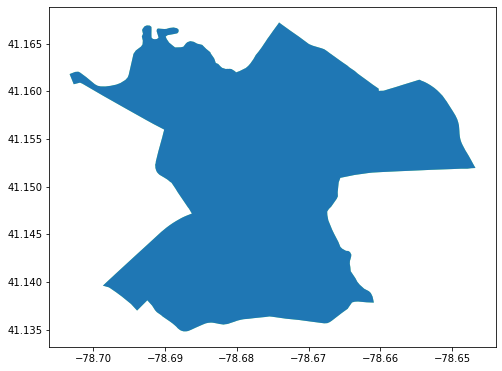

In [16]:
ax = polygon_zone6.plot(figsize = (8, 10), color = 'lightgreen')
may_zone6.plot( ax = ax, column = 'sumdid');
plt.show();

Put it on a map

In [17]:
polygon_zone6.geometry.centroid

C:\Users\jojuk\AppData\Local\Temp/ipykernel_16996/1119009884.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon_zone6.geometry.centroid


5    POINT (-78.67593 41.15125)
dtype: geometry

In [18]:
center = polygon_zone6.geometry.centroid[5]
print(center)

POINT (-78.67592558418018 41.15125178828045)


C:\Users\jojuk\AppData\Local\Temp/ipykernel_16996/3696582550.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = polygon_zone6.geometry.centroid[5]


In [19]:
area_center = [center.y, center.x]
print(area_center)

[41.151251788280454, -78.67592558418018]


In [20]:
map_zone6 = folium.Map(location =  area_center, zoom_start = 12)
map_zone6

In [21]:
i = 0
for row_index, row_values in may_zone6.iterrows():
    if i <3: 
        print('index is', row_index)
        print('values are:')
        print(' ')
        print(row_values)
        print('------------------------- ')
        i+=1

index is 5
values are:
 
pubdatetime                           2019-05-01 00:01:41.247000
latitude                                               36.157188
longitude                                             -86.769978
sumdid                                              Powered3F3VK
chargelevel                                                 82.0
companyname                                                    0
geometry       POLYGON ((-78.6635793624513 41.16211373242018,...
index_right                                                    5
ZONE_ID                                                        6
Name: 5, dtype: object
------------------------- 


In [23]:
map_zone6 = folium.Map(location =  area_center, zoom_start = 13)

marker_cluster = MarkerCluster().add_to(map_zone6)

folium.GeoJson(polygon_zone6).add_to(map_zone6)

for row_index, row_values in may_zone6.iterrows():
    loc = [row_values['latitude'], row_values['longitude']]
    tool = [str(row_values['sumdid']), str(row_values['pubdatetime'])]
    icon=folium.Icon(color="blue",icon="map-pin", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        tooltip = tool, icon = icon) 

    marker.add_to(marker_cluster)
map_zone6.save('../data/map_zone6.html')

#display our map
map_zone6